In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import math
import cv2
import os
import torchvision.transforms as transforms
from PIL import Image 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.models import Model,load_model
import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint


current_dir = os.getcwd()
VGG16_weight = current_dir + "/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
print(current_dir)

def display_files(number_displayed, data):
    RGB_dataA_files = sorted(os.listdir(current_dir + "/archive-2/"+data+"/"+data+"/CameraRGB"))[:number_displayed]
    Seg_dataA_files = sorted(os.listdir(current_dir + "/archive-2/"+data+"/"+data+"/CameraSeg"))[:number_displayed]
    
    for i in range(len(RGB_dataA_files)):
        RGB_dataA_files[i] = cv2.imread(current_dir + "/archive-2/"+data+"/"+data+"/CameraRGB/" + RGB_dataA_files[i])
        Seg_dataA_files[i] = cv2.imread(current_dir + "/archive-2/"+data+"/"+data+"/CameraSeg/" + Seg_dataA_files[i], cv2.IMREAD_GRAYSCALE)

    fig, axes = plt.subplots(len(RGB_dataA_files), 2, figsize=(10, 15))
    axes[0, 0].set(title = f"Original Image")
    axes[0, 1].set(title = f"Mask Image")
    for i in range(len(RGB_dataA_files)):
        axes[i][0].imshow(RGB_dataA_files[i])
        axes[i][1].imshow(Seg_dataA_files[i])

    plt.show()

# display_files(3, "dataA")

def store_data(data):
    RGB_files = sorted(os.listdir(current_dir + "/archive-2/"+data+"/"+data+"/CameraRGB"))
    Seg_files = sorted(os.listdir(current_dir + "/archive-2/"+data+"/"+data+"/CameraSeg"))
    for i in range(len(RGB_files)):
        RGB_files[i] = current_dir + "/archive-2/"+data+"/"+data+"/CameraRGB/" + RGB_files[i]
    for i in range(len(Seg_files)):
        Seg_files[i] = current_dir + "/archive-2/"+data+"/"+data+"/CameraSeg/" + Seg_files[i]

    return (RGB_files, Seg_files)

image_files = []
mask_files = []
image_files += store_data("dataA")[0]
image_files += store_data("dataB")[0]
image_files += store_data("dataC")[0]
image_files += store_data("dataD")[0]
image_files += store_data("dataE")[0]

mask_files += store_data("dataA")[1]
mask_files += store_data("dataB")[1]
mask_files += store_data("dataC")[1]
mask_files += store_data("dataD")[1]
mask_files += store_data("dataE")[1]

print(image_files[100] + "\n" + mask_files[100])


train_images_dir , test_images_dir , train_masks_dir , test_masks_dir = train_test_split(image_files , mask_files , test_size = 0.01)



2024-05-09 02:00:57.974065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/dez004/Untitled Folder
/home/dez004/Untitled Folder/archive-2/dataA/dataA/CameraRGB/02_02_000.png
/home/dez004/Untitled Folder/archive-2/dataA/dataA/CameraSeg/02_02_000.png


In [2]:

input_shape = (224, 224, 3)

# segmentation model definer

def create_segmentation_model(input_shape):
    base_model = vgg16.VGG16(include_top=False, input_shape=input_shape, weights=VGG16_weight)
    
    #uncomment this if want to disable back propagation
    # for layer in base_model.layers:
    #     layer.trainable = False
    
    #encoder
    encoder_output = base_model.output
    
    #decoder
    '''first upsample'''
    x = UpSampling2D(size=(2, 2))(encoder_output)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
    skip_connection_layer = base_model.get_layer('block5_conv3').output
    x = concatenate([x, skip_connection_layer])
    
    '''Second upsample'''
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
    skip_connection_layer = base_model.get_layer('block4_conv3').output
    x = concatenate([x, skip_connection_layer])
    
    '''third upsample'''
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
    skip_connection_layer = base_model.get_layer('block3_conv3').output
    x = concatenate([x, skip_connection_layer])
    
    '''fourth upsample'''
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
    skip_connection_layer = base_model.get_layer('block2_conv2').output
    x = concatenate([x, skip_connection_layer])
    
    '''fifth upsample'''
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
    skip_connection_layer = base_model.get_layer('block1_conv2').output
    x = concatenate([x, skip_connection_layer])
    
    
    #output layer
    output = Conv2D(filters=13, kernel_size=(1, 1), activation='softmax', padding='same')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model


def one_hot_encode_masks(masks, num_classes=13):
    # Assume masks are single-channel with class indices
    masks = tf.cast(masks, tf.int32)
    one_hot_masks = tf.one_hot(masks, depth=num_classes)
    # Remove the channel dimension added by tf.one_hot
    if one_hot_masks.shape[-2] == 1:
        one_hot_masks = tf.squeeze(one_hot_masks, axis=-2)  # Squeeze only if the second last dimension is 1
    return one_hot_masks

def load_and_preprocess_image(image_path, mask_path):
    # Load image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0  # Normalize image

    # Load mask and convert it to a single-channel class index format
    mask = load_img(mask_path, color_mode='grayscale', target_size=(224, 224))  # Ensure this matches your mask format
    mask = img_to_array(mask)
    mask = mask.reshape((224, 224))  # Ensure mask is single-channel
    mask = one_hot_encode_masks(mask, num_classes=13)

    return image, mask


# Generator function to yield preprocessed images and masks
def train_image_mask_generator():
    for img_path, mask_path in zip(train_images_dir, train_masks_dir):
        image, mask = load_and_preprocess_image(img_path, mask_path)
        yield image, mask

def valid_image_mask_generator():
    for img_path, mask_path in zip(test_images_dir, test_masks_dir):
        image, mask = load_and_preprocess_image(img_path, mask_path)
        yield image, mask
        
# Create TensorFlow dataset from generator
';'
train_dataset = tf.data.Dataset.from_generator(train_image_mask_generator,
                                         output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(224, 224, 13), dtype=tf.float32)))
val_dataset = tf.data.Dataset.from_generator(valid_image_mask_generator,
                                         output_signature=(tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(224, 224, 13), dtype=tf.float32)))
batch_size = 5
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()
val_dataset = val_dataset.batch(batch_size)
print(train_dataset)
print(val_dataset)


model = create_segmentation_model(input_shape=(224, 224, 3))  # Assuming n classes including background
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpoint_dir = current_dir+'/checkpoints1/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}-{val_loss:.2f}.h5')
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True, 
    verbose=1)


model.summary()

2024-05-09 02:01:05.159750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9986 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


<_RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 13), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 13), dtype=tf.float32, name=None))>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)       

In [3]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100, 
    steps_per_epoch=20,
#     verbose=1,
    callbacks=[early_stopping]
)


model.save('finished-test6.keras')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

Epoch 1/100


2024-04-26 20:52:34.747570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-26 20:52:37.848972: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa5f93f38d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-26 20:52:37.849047: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-04-26 20:52:37.858496: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-26 20:52:38.070571: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 [==============================] - 24s 506ms/step - loss: 1.7274 - accuracy: 0.6011 - val_loss: 0.6288 - val_accuracy: 0.7992
Epoch 2/100
20/20 [==============================] - 9s 444ms/step - loss: 0.4472 - accuracy: 0.8530 - val_loss: 0.3442 - val_accuracy: 0.8806
Epoch 3/100
12/20 [=================>............] - ETA: 2s - loss: 0.3068 - accuracy: 0.8958

KeyboardInterrupt: 

In [3]:
best_model = load_model('finished-test6.keras')
test_loss, test_accuracy = model.evaluate(val_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2024-05-09 02:01:17.869659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


     10/Unknown - 6s 230ms/step - loss: 12.8336 - accuracy: 0.0182

2024-05-09 02:01:22.632073: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16783005120581923625
2024-05-09 02:01:22.632215: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6194855776929840675


10/10 [==============================] - 7s 273ms/step - loss: 12.8336 - accuracy: 0.0182
Test Loss: 12.83358383178711
Test Accuracy: 0.01823541149497032


1/1 [==============================] - 1s 990ms/step


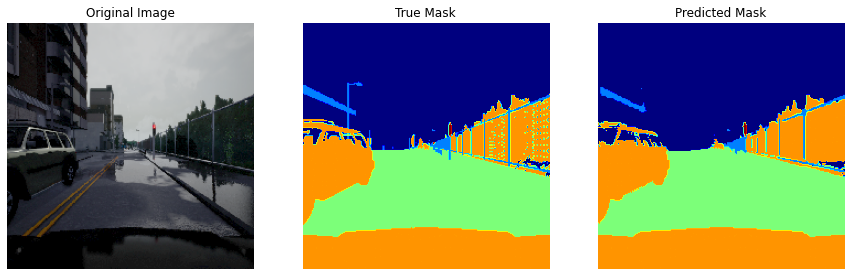

1/1 [==============================] - 0s 36ms/step


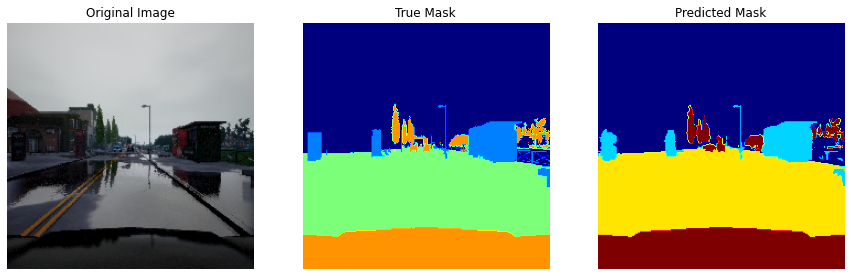

1/1 [==============================] - 0s 40ms/step


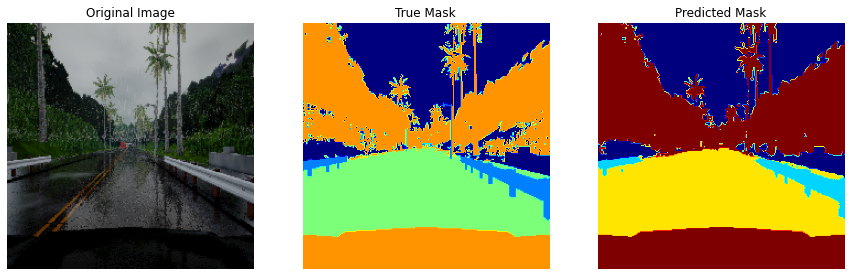

1/1 [==============================] - 0s 40ms/step


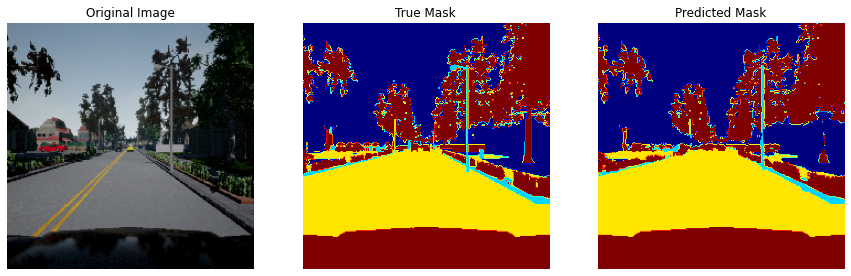

1/1 [==============================] - 0s 39ms/step


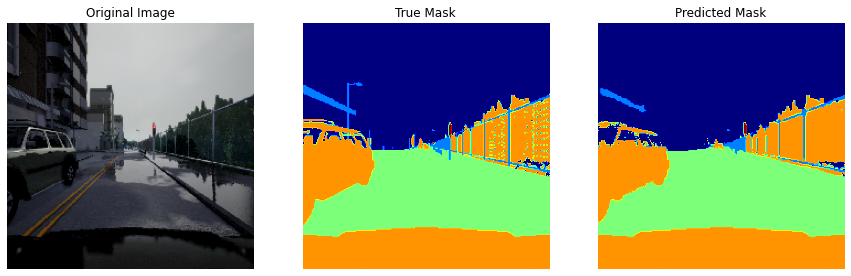

In [4]:
def preprocess_input_image(image_path, target_size=(224, 224)):
    # Load the image
    image = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    image_array = img_to_array(image)
    # Normalize the image
    image_array = image_array / 255.0
    # Add a batch dimension
    image_array = np.expand_dims(image_array, axis=0)
    return image_array
            
def predict_mask(model, image_array):
    # Predict the mask
    prediction = model.predict(image_array)
    return prediction
            
            
def postprocess_prediction(prediction, target_size=(224, 224)):
    # Take the argmax across channels to convert to class indices
    predicted_mask = np.argmax(prediction, axis=-1)
    # Remove the batch dimension
    predicted_mask = predicted_mask[0]
    return predicted_mask

model = load_model('finished-test6.keras')

def display(index, target_size=(224, 224)):
    img_path = image_files[index]
    mask_path = mask_files[index]
    image_array = preprocess_input_image(img_path)
    prediction = predict_mask(model, image_array)
    predicted_mask = postprocess_prediction(prediction)
    
    # Load and display the original image
    original_image = load_img(img_path, target_size=target_size)
    
    true_mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')
    true_mask = np.squeeze(np.array(true_mask))  # Remove if unnecessary
    
    # Display the predicted mask
    # Ensure predicted_mask is correctly postprocessed to be displayable
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')  # Turn off axis
    
    ax[1].imshow(true_mask, cmap='jet')  # Use appropriate colormap
    ax[1].set_title("True Mask")
    ax[1].axis('off')  # Turn off axis
    
    ax[2].imshow(predicted_mask, cmap='jet')  # Use appropriate colormap
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')  # Turn off axis
    
    plt.show()

    
display(1000)
display(500)
display(200)
display(100)
display(1)

In [19]:
# def Intersection_Over_Union(target_tensor, prediction_tensor):
#     target = target_tensor[0].numpy()
#     prediction = prediction_tensor[0].numpy()
#     intersection = np.logical_and(target, prediction)
#     union = np.logical_or(target, prediction)
#     iou_score = np.sum(intersection) / np.sum(union)
#     print('IOU : ', iou_score)
    
    
    
# def Intersection_Over_Union(target_tensor, prediction_tensor):
#     target = target_tensor[0].numpy() if not isinstance(target_tensor[0], np.ndarray) else target_tensor[0]
#     prediction = prediction_tensor[0].numpy() if not isinstance(prediction_tensor[0], np.ndarray) else prediction_tensor[0]

#     intersection = np.logical_and(target, prediction)
#     union = np.logical_or(target, prediction)

#     intersection_sum = np.sum(intersection)
#     union_sum = np.sum(union)

#     if union_sum == 0:
#         print('IOU: No overlap or both target and prediction are empty')
#         return 0.0
#     else:
#         iou_score = intersection_sum / union_sum
#         print('IOU:', iou_score)
#         return iou_score

def Intersection_Over_Union(target_tensor, prediction_tensor):
    target = target_tensor.numpy()
    prediction = prediction_tensor.numpy() 
    accuracy = 0
    count = 0
    for i in range(len(target)):
        for j in range(len(target[0])):
            if target[i][j] == prediction[i][j]:
                accuracy += 1
            count += 1
    
#     print(accuracy/count)
    return accuracy/count
    
def IOU_Mask_Comparison(index, target_size=(224,224)):
    img_path = image_files[index]
    image_array = preprocess_input_image(img_path)
    mask_path = mask_files[index]
    prediction = predict_mask(model, image_array)
    predicted_mask = postprocess_prediction(prediction)
    true_mask = load_img(mask_path, target_size=target_size,  color_mode='grayscale')
    true_mask = np.squeeze(np.array(true_mask)) 
    Intersection_Over_Union(torch.from_numpy(true_mask), torch.from_numpy(predicted_mask))

    
def IOU_Direction_Comparison(dirpath, img_path, target_size=(224,224)):
    image_array = preprocess_input_image(img_path)
    prediction = predict_mask(model, image_array)
    predicted_mask = postprocess_prediction(prediction)
    direction_img = load_img(dirpath, target_size=target_size, color_mode='grayscale')
    direction_img = np.squeeze(np.array(direction_img)) 
    Intersection_Over_Union(torch.from_numpy(direction_img), torch.from_numpy(predicted_mask))
    
    
def displayComparison(dirpath, img_path, target_size=(224, 224)):
    image_array = preprocess_input_image(img_path)
    prediction = predict_mask(model, image_array)
    predicted_mask = postprocess_prediction(prediction)
    
    # Load and display the original image
    original_image = load_img(img_path, target_size=target_size)
    direction_image = load_img(dirpath, target_size=target_size)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(original_image, cmap='jet')
    ax[0].set_title("Original Image")
    ax[0].axis('off')  # Turn off axis
    
    ax[1].imshow(predicted_mask, cmap='jet')  # Use appropriate colormap
    ax[1].set_title("Predicted Mask")
    ax[1].axis('off')  # Turn off axis
    
    ax[2].imshow(direction_image, cmap='jet')  # Use appropriate colormap
    ax[2].set_title("Direction")
    ax[2].axis('off')  # Turn off axis
    
    plt.show()
    
    

1/1 [==============================] - 0s 36ms/step
0.9647241709183674
1/1 [==============================] - 0s 33ms/step
0.9619339923469388
1/1 [==============================] - 0s 38ms/step


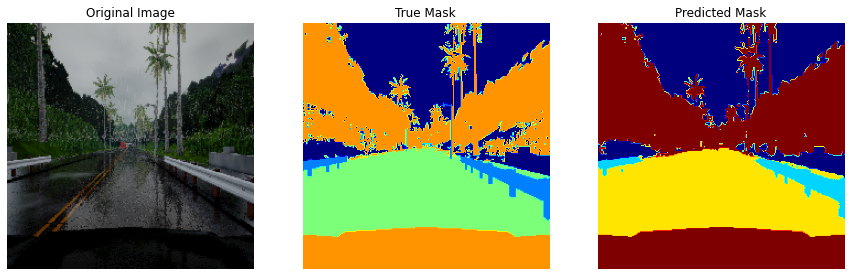

1/1 [==============================] - 0s 27ms/step


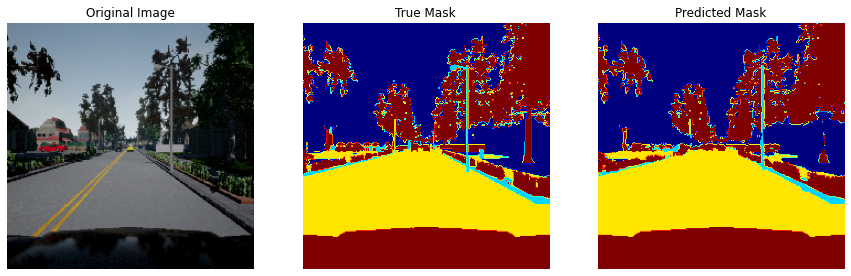

1/1 [==============================] - 0s 33ms/step
0.2116749043367347
1/1 [==============================] - 0s 42ms/step


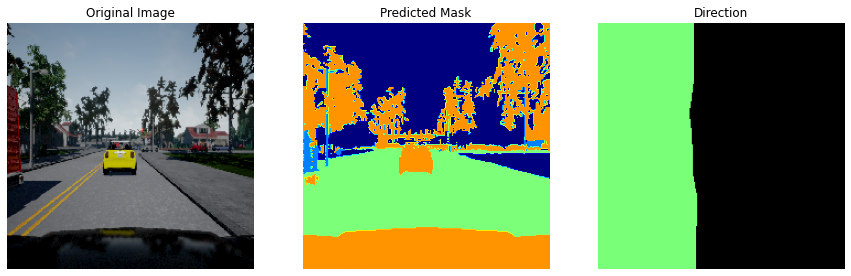

1/1 [==============================] - 0s 33ms/step
0.2116749043367347
1/1 [==============================] - 0s 32ms/step


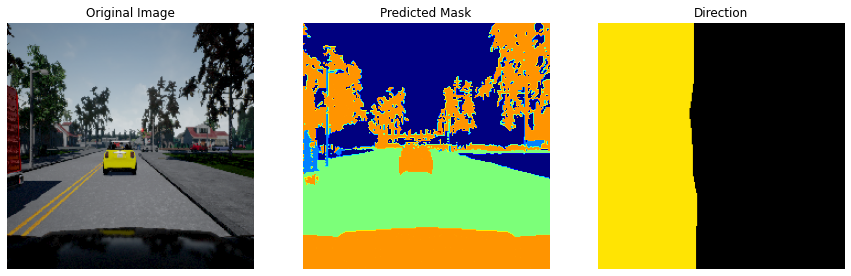

In [17]:
IOU_Mask_Comparison(200)
IOU_Mask_Comparison(100)
display(200)
display(100)

img_path = image_files[130]
dirpath = os.getcwd()+"/directions/leftgre.png"
IOU_Direction_Comparison(dirpath, img_path)
displayComparison(dirpath, img_path)
dirpath = os.getcwd()+"/directions/leftyel.png"
IOU_Direction_Comparison(dirpath, img_path)
displayComparison(dirpath, img_path)

1/1 [==============================] - 0s 38ms/step
0
true mask:   0.47066326530612246
predicted mask:    0.4746890943877551
1
true mask:   0.049505739795918366
predicted mask:    0.046775350765306124
2
true mask:   0.3051658163265306
predicted mask:    0.30576371173469385
3
true mask:   0.17452566964285715
predicted mask:    0.1727718431122449
4
true mask:   0.00013950892857142856
predicted mask:    0.0
5
true mask:   0.0
predicted mask:    0.0
6
true mask:   0.0
predicted mask:    0.0
7
true mask:   0.0
predicted mask:    0.0
8
true mask:   0.0
predicted mask:    0.0
9
true mask:   0.0
predicted mask:    0.0
10
true mask:   0.0
predicted mask:    0.0
11
true mask:   0.0
predicted mask:    0.0
12
true mask:   0.0
predicted mask:    0.0


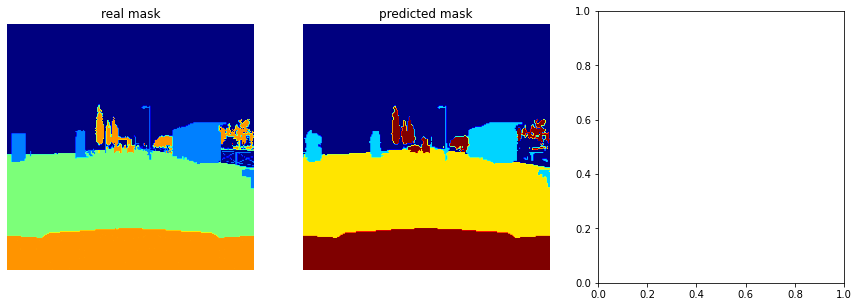

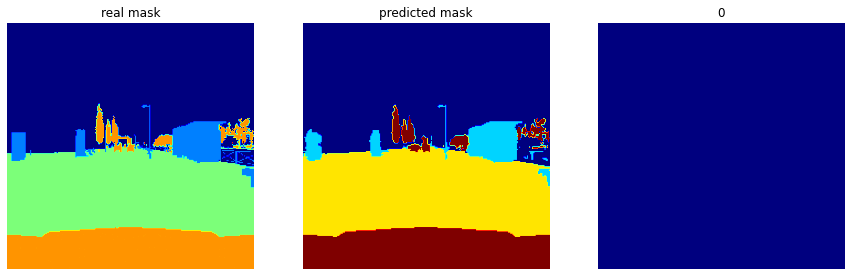

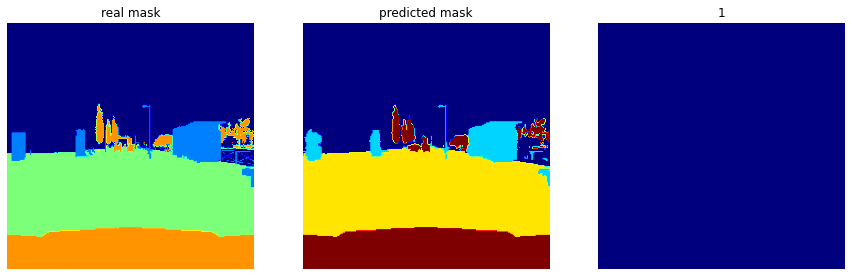

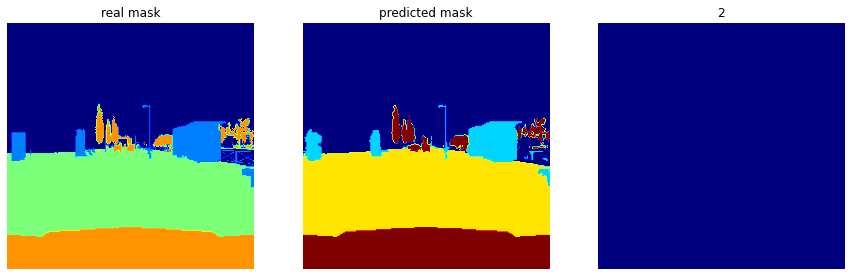

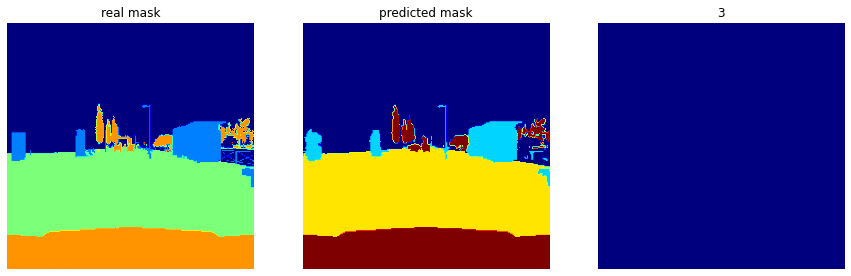

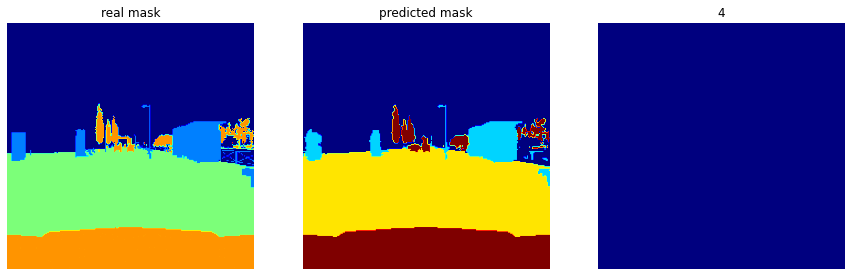

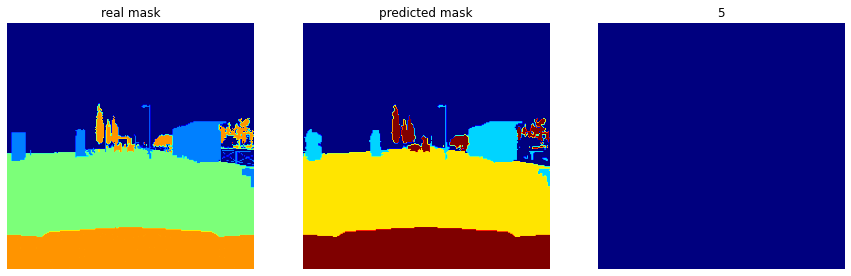

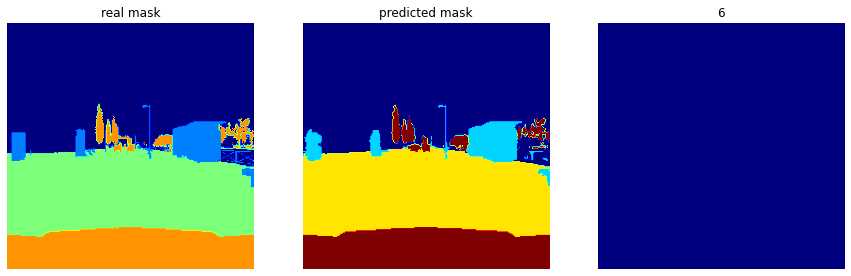

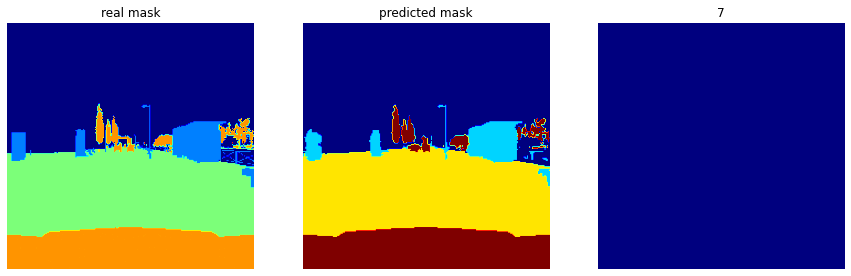

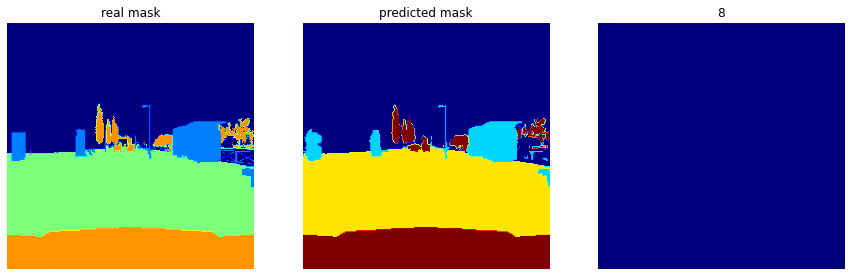

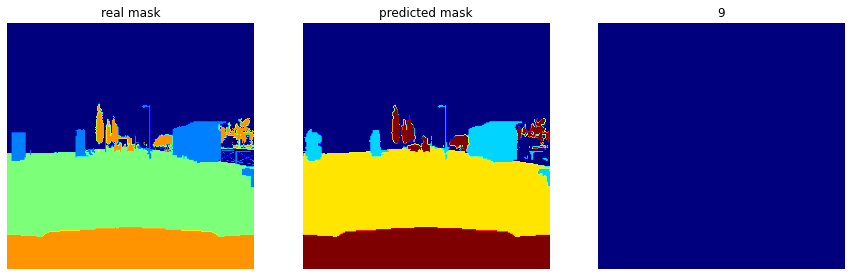

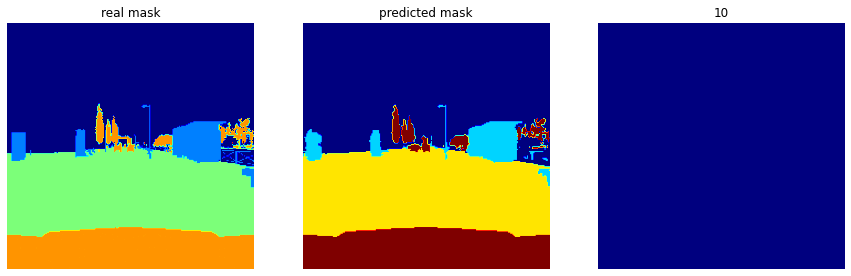

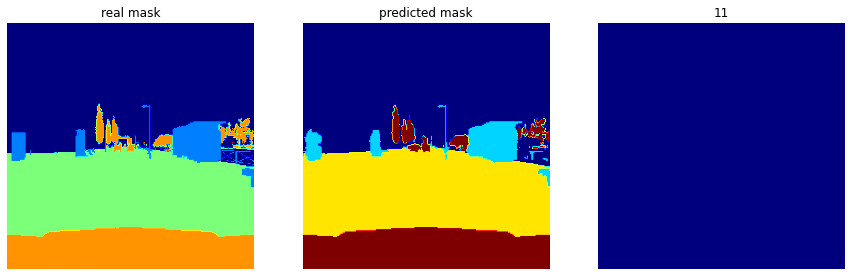

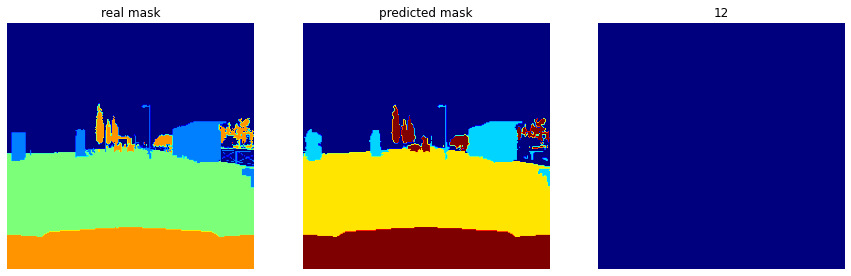

In [21]:
from PIL import Image

# # Open the image
# image = Image.open(mask_files[130])

# # Get the width and height of the image
# width, height = image.size

# # Iterate over each pixel in the image
# for x in range(width):
#     for y in range(height):
#         # Get the pixel value at (x, y)
#         pixel_value = image.getpixel((x, y))

#         # Print the pixel value
#         print(pixel_value)

target_size=(224,224)

img_path = image_files[500]
image_array = preprocess_input_image(img_path)
mask_path = mask_files[500]
prediction = predict_mask(model, image_array)
predicted_mask = postprocess_prediction(prediction)
true_mask = load_img(mask_path, target_size=target_size,  color_mode='grayscale')
true_mask = np.squeeze(np.array(true_mask)) 
# img = load_img(os.getcwd()+f'/color0.png', target_size=target_size,  color_mode='grayscale')
# img = np.squeeze(np.array(img)) 
# print("True Mask:  ", true_mask[0], "   Predicted Mask:   ", predicted_mask[0], "   Testing Mask 0:  ", img[0])
# Intersection_Over_Union(torch.from_numpy(true_mask), torch.from_numpy(predicted_mask))
# IOU_Mask_Comparison(200)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(true_mask, cmap='jet')
ax[0].set_title("real mask")
ax[0].axis('off')  # Turn off axis

ax[1].imshow(predicted_mask, cmap='jet')
ax[1].set_title("predicted mask")
ax[1].axis('off')  # Turn off axis

for i in range (0, 13):
    temp = []
    pixels = []
    for j in range(0, 225):
        temp.append(i)
    for o in range (0, 225):
        pixels.append(temp)
    array = np.array(pixels, dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.save(f'color{i}.png')
    
    
    
for i in range (0, 13):
    image = load_img(os.getcwd()+f'/color{i}.png', target_size=target_size, color_mode = 'grayscale')
    image = np.squeeze(np.array(image))
    print(i)
    print("true mask:  ", Intersection_Over_Union(torch.from_numpy(true_mask), torch.from_numpy(image)))
    print("predicted mask:   ", Intersection_Over_Union(torch.from_numpy(predicted_mask), torch.from_numpy(image)))

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(true_mask, cmap='jet')
    ax[0].set_title("real mask")
    ax[0].axis('off')  # Turn off axis

    ax[1].imshow(predicted_mask, cmap='jet')
    ax[1].set_title("predicted mask")
    ax[1].axis('off')  # Turn off axis
    
    ax[2].imshow(image, cmap='jet')
    ax[2].set_title(i)
    ax[2].axis('off')  # Turn off axis
#     print('image ', i, '  True Mask:  ', true_mask[100], "   Predicted Mask:   ", predicted_mask[100], "   Testing Mask:  ", image[100])
#     print('image ', i, '  True Mask:  ', torch.from_numpy(true_mask).type(), "   Predicted Mask:   ", torch.from_numpy(predicted_mask).type(), "   Testing Mask 0:  ", torch.from_numpy(image).type())
    
# target_size=(1000,1300)
# temp = []
# pixels = []
# for i in range (0, 13):    
#     for j in range(0, 1000):
#         temp.append((i,0,0))
#     for o in range (0, 100):
#         pixels.append(temp)
# array = np.array(pixels, dtype=np.uint8)
# new_image = Image.fromarray(array)
# new_image.save('allcolor.png')
# image = load_img(os.getcwd()+'/allcolor.png', target_size=target_size, color_mode='grayscale')
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].imshow(image, cmap='jet')
# ax[0].set_title('allcolor')
# ax[0].axis('off')  # Turn off axis
    
# # Convert the pixels into an array using numpy
# array = np.array(pixels, dtype=np.uint8)

# # Use PIL to create an image from the new array of pixels
# new_image = Image.fromarray(array)
# new_image.save('allcolors.png')

# image = load_img(os.getcwd()+"/allcolors.png", target_size=target_size, color_mode='grayscale')
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].imshow(image, cmap='jet')
# ax[0].set_title("Image")
# ax[0].axis('off')  # Turn off axis

In [ ]:
def display_test(target_size=(224, 224)):
    current_dir = os.getcwd()
    img_path = current_dir+"/test.jpeg"
    image_array = preprocess_input_image(img_path)
    prediction = predict_mask(model, image_array)
    predicted_mask = postprocess_prediction(prediction)
    
    # Load and display the original image
    original_image = load_img(img_path, target_size=target_size)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')  # Turn off axis
    
    ax[1].imshow(predicted_mask, cmap='jet')  # Use appropriate colormap
    ax[1].set_title("Predicted Mask")
    ax[1].axis('off')  # Turn off axis
    
    plt.show()

In [ ]:
display_test()